# **Project Name - Content analysis and engagement on social media**
#### (Instagram, TikTok, Facebook, YouTube)

##### **Project Type**    - EDA
##### Auyhor: Prasolova S.

# **Project Summary -**

#### Analysis Goal
The goal of this EDA was to:
1. Assess and improve data quality;
2. Compare engagement across social media platforms;
3. Identify posting time patterns;
4. Analyze engagement distribution and trends over time.

#### Dataset Overview
The dataset contains ~10,000 posts from 4 platforms:
- platform (publishing platform)
- created_time (date and time of post creation)
- likes_count, comments_count, shares_count, views_count (engagement metrics)
- text_original (post text)
##### Based on the basic metrics, the following was calculated:
engagement = likes + comments + shares

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas as pd, csv

# 1.Data Verification and Cleaning (Data Quality)
#### 1.1 File normalization

In [5]:
# when loading and opening the file, lines or format were detected that cannot be processed correctly (excessively long fields, non-standard quoting/delimiter, etc.)
# therefore we use: see the first 2000 bytes (binary)
path = r"C:\Users\Світлана\Downloads\test_sample.csv"
with open(path, "rb") as f:
    chunk = f.read(2000)
print(chunk[:1000])

b'platform,account_id,id,created_time,text_original,text_additional,likes_count,shares_count,comments_count,views_count\nInstagram,59141296785,C_00PPctR-o,2024-09-12 17:20:36.000000 +00:00,"",,222,,34,\nInstagram,60554087008,C_00W8KttVv,2024-09-12 17:21:27.000000 +00:00,"C\xe2\x80\x99\xc3\xa8 un gruppo sulla parola di Dio sulla mia homepage personale\n\xf0\x9f\x91\x89 (@lamore_della_vergine_maria )\n\xf0\x9f\x91\x86\xe1\xb4\x9b\xe1\xb4\x8f\xe1\xb4\x84\xe1\xb4\x84\xe1\xb4\x80 \xc9\xaa\xca\x9f \xca\x9f\xc9\xaa\xc9\xb4\xe1\xb4\x8b \xe1\xb4\x85\xc9\xaa \xe1\xb4\xa1\xca\x9c\xe1\xb4\x80\xe1\xb4\x9b\xea\x9c\xb1\xe1\xb4\x80\xe1\xb4\x98\xe1\xb4\x98 per iscriverti gratuitamente, sta per arrivare una buona notizia che pu\xc3\xb2 cambiare il tuo destino e quello della tua famiglia.\nOggi noi esseri umani affrontiamo varie difficolt\xc3\xa0 e sofferenze, tutte causate dalla corruzione di Satana. Dio conosce il nostro dolore e vuole salvarci dalla nostra sofferenza Stasera abbiamo un meraviglioso ca

In [7]:
path = r"C:\Users\Світлана\Downloads\test_sample.csv"   

def count_fields_outside_quotes(line, quotechar='"', sep=','):    # Diagnostics: finding rows with an inconsistent number of fields
    in_q = False
    fields = 1
    i = 0
    while i < len(line):
        ch = line[i]
        if ch == quotechar:
                                                                  # simple approach: toggle state, but if double quotes are like escape (""), skip one
            if i+1 < len(line) and line[i+1] == quotechar:
                i += 1  # skip escaped quote
            else:
                in_q = not in_q
        elif ch == sep and not in_q:
            fields += 1
        i += 1
    return fields

# first pass: read the header and set the expected number of fields
with open(path, 'r', encoding='utf-8', errors='replace') as f:
    header = f.readline()
expected = count_fields_outside_quotes(header)
print("Expected fields (from header):", expected)

bad_lines = []
with open(path, 'r', encoding='utf-8', errors='replace') as f:
    for i, line in enumerate(f, start=1):              # we start with 1 — but all rows are taken into account
        n = count_fields_outside_quotes(line)
        if n != expected:
            bad_lines.append((i+1, n, line[:300]))  # i+1 are taken into account if we took into account the header beforehand

print("Found", len(bad_lines), "inconsistent lines. First 10:")
for rec in bad_lines[:10]:
    print(rec)

Expected fields (from header): 10
Found 24167 inconsistent lines. First 10:
(4, 5, 'Instagram,60554087008,C_00W8KttVv,2024-09-12 17:21:27.000000 +00:00,"C’è un gruppo sulla parola di Dio sulla mia homepage personale\n')
(5, 1, '👉 (@lamore_della_vergine_maria )\n')
(6, 2, '👆ᴛᴏᴄᴄᴀ ɪʟ ʟɪɴᴋ ᴅɪ ᴡʜᴀᴛꜱᴀᴘᴘ per iscriverti gratuitamente, sta per arrivare una buona notizia che può cambiare il tuo destino e quello della tua famiglia.\n')
(7, 4, 'Oggi noi esseri umani affrontiamo varie difficoltà e sofferenze, tutte causate dalla corruzione di Satana. Dio conosce il nostro dolore e vuole salvarci dalla nostra sofferenza Stasera abbiamo un meraviglioso catechismo online per aiutarti a scoprire il mistero di come il Signore Gesù ritorna per sa')
(8, 1, '#SanPietro\n')
(9, 1, '#Chiesa\n')
(10, 1, '#SantaGiulia\n')
(11, 1, '#SantoSpirito\n')
(12, 1, '#SanGiuseppe\n')
(13, 1, '#SanBiagio\n')


##### We see that the problem is confirmed: you have many physical rows that belong to one logical record (due to line wrapping in the text_original field). The next step is to merge the physical rows into logical rows (i.e., collect several physical rows until the number of fields matches the expected one), write the “cleaned” CSV and read it through pandas.

In [9]:
import os
import pandas as pd

path = r"C:\Users\Світлана\Downloads\test_sample.csv"
clean_path = r"C:\Users\Світлана\Downloads\test_sample_cleaned.csv"

# Function — count separators outside quotes
def count_fields_outside_quotes(line, quotechar='"', sep=','):
    in_q = False
    fields = 1
    i = 0
    L = len(line)
    while i < L:
        ch = line[i]
        if ch == quotechar:
            # if we encounter double quotes as escape -> we skip one
            if i + 1 < L and line[i + 1] == quotechar:
                i += 1
            else:
                in_q = not in_q
        elif ch == sep and not in_q:
            fields += 1
        i += 1
    return fields

# Find out the expected number of fields from the header
with open(path, 'r', encoding='utf-8', errors='replace') as f:
    header = f.readline().rstrip('\n\r')
expected = count_fields_outside_quotes(header)
print("Expected fields (from header):", expected)

# Gluing physical rows into logical rows
# Work row by row, write only complete logical records
written = 0
problem_buffers = 0

with open(path, 'r', encoding='utf-8', errors='replace') as src, \
     open(clean_path, 'w', encoding='utf-8', newline='') as dst:
    dst.write(header + '\n')  # write header to clean file
    buffer = ''
    for raw in src:
        line = raw.rstrip('\n\r')
        if buffer == '':
            buffer = line
        else:
# We add the physical string as a real \n inside the field —
# this preserves the hyphenation in the text if it was correct
            buffer += '\n' + line
# test whether buffer contains the expected number of fields
        if count_fields_outside_quotes(buffer) == expected:
            dst.write(buffer + '\n')
            written += 1
            buffer = ''
        else:
# if the buffer becomes very long, this is a sign of an incorrect/slightly corrupted record
            if len(buffer) > 5_000_000:  # 5MB як страховка
                # збережемо та скипнемо, щоб не застрягати на одному записі
                dst.write(buffer + '\n')
                problem_buffers += 1
                buffer = ''

# if something remains in the buffer — we will write it as the last line (possibly incomplete)
    if buffer:
        dst.write(buffer + '\n')
        problem_buffers += 1

print(f"Finished writing cleaned file: {clean_path}")
print(f"Logical rows written (excluding header): {written}")
print(f"Buffers force-flushed as problems: {problem_buffers}")
print("Clean file size (bytes):", os.path.getsize(clean_path))


Expected fields (from header): 10
Finished writing cleaned file: C:\Users\Світлана\Downloads\test_sample_cleaned.csv
Logical rows written (excluding header): 10001
Buffers force-flushed as problems: 0
Clean file size (bytes): 3870602


In [11]:
df_fb = pd.read_csv(r"C:\Users\Світлана\Downloads\test_sample_cleaned.csv") 
# open the edited file
df_fb.head()

,platform,account_id,id,created_time,text_original,text_additional,likes_count,shares_count,comments_count,views_count
0,platform,account_id,id,created_time,text_original,text_additional,likes_count,shares_count,comments_count,views_count
1,Instagram,59141296785,C_00PPctR-o,2024-09-12 17:20:36.000000 +00:00,NaN,NaN,222,NaN,34,NaN
2,Instagram,60554087008,C_00W8KttVv,2024-09-12 17:21:27.000000 +00:00,C’è un gruppo sulla parola di Dio sulla mia ho...,NaN,391,NaN,37,NaN
3,Instagram,62605500679,C_026U_t3We,2024-09-12 17:43:38.000000 +00:00,𝐒𝐮𝐥 𝐦𝐢𝐨 𝐩𝐫𝐨𝐟𝐢𝐥𝐨 𝐜‘𝐞̀ 𝐮𝐧 𝐠𝐫𝐮𝐩𝐩𝐨 𝐝𝐢 𝐬𝐭𝐮𝐝𝐢𝐨 𝐬𝐮𝐥𝐥𝐚...,NaN,9,NaN,3,NaN
4,Instagram,58741537308,C_05B3hCYQn,2024-09-12 18:02:08.000000 +00:00,#Monza\n#Padova\n#Lecce\n#Latina\n#paroladelsi...,NaN,78,NaN,15,NaN


#### 1.2 Check and improve data quality (remove duplicates and fill empty NaN values)

In [3]:
import pandas as pd
import numpy as np

In [4]:
df_fb = pd.read_csv(r"C:\Users\Світлана\Downloads\test_sample_cleaned.csv")
df_fb.info()             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10526 entries, 0 to 10525
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   platform         10526 non-null  object
 1   account_id       10001 non-null  object
 2   id               10048 non-null  object
 3   created_time     10001 non-null  object
 4   text_original    7661 non-null   object
 5   text_additional  4 non-null      object
 6   likes_count      9952 non-null   object
 7   shares_count     5001 non-null   object
 8   comments_count   9909 non-null   object
 9   views_count      5622 non-null   object
dtypes: object(10)
memory usage: 822.5+ KB


In [5]:
print(df_fb.count())         # identify duplicates
print(df_fb.nunique())

platform           10526
account_id         10001
id                 10048
created_time       10001
text_original       7661
text_additional        4
likes_count         9952
shares_count        5001
comments_count      9909
views_count         5622
dtype: int64
platform              80
account_id           102
id                 10046
created_time        9983
text_original       5727
text_additional        2
likes_count         2644
shares_count         367
comments_count      1375
views_count         4257
dtype: int64


In [6]:
df_fb.duplicated().sum()

np.int64(415)

In [7]:
df_fb = df_fb.drop_duplicates()   # remove full duplicate rows to avoid double-counting metrics

In [8]:
df_fb.duplicated().sum()          # check

np.int64(0)

In [9]:
df_fb.isna().sum()          

platform               0
account_id           110
id                    63
created_time         110
text_original       2450
text_additional    10107
likes_count          159
shares_count        5110
comments_count       202
views_count         4489
dtype: int64

In [10]:
df_fb['created_time'] = pd.to_datetime(         # Cast created_time to timestamp and handle 525 gaps
    df_fb['created_time'],
    format='%Y-%m-%d %H:%M:%S.%f %z',
    errors='coerce'
)

In [11]:
df_fb['created_time'].isna().sum()              # Check
df_fb['created_time'].dtype

datetime64[ns, UTC]

In [12]:
# CAST metrics to numeric + gap filling
# Problem: shares_count, views_count stored as string. Large number of NaN: shares_count: 5525; views_count: 4904 

metrics = ['likes_count', 'shares_count', 'comments_count', 'views_count']

for col in metrics:
    df_fb[col] = pd.to_numeric(df_fb[col], errors='coerce')

In [13]:
df_fb[metrics] = df_fb[metrics].fillna(0)       # Engagement metrics were cast to numeric type, missing engagement metrics values ​​were replaced with 0.

In [14]:
df_fb = df_fb.dropna(subset=['account_id', 'id'])  # Records without account or post IDs were removed because they cannot be used correctly in the analysis.

In [15]:
df_fb['text_original'] = df_fb['text_original'].fillna('')
df_fb['text_additional'] = df_fb['text_additional'].fillna('')  # Omitted text fields were replaced with an empty string for text analysis to work correctly.


In [16]:
df_fb.duplicated(subset=['platform', 'id']).sum() # Check logical uniqueness of posts


np.int64(0)

In [17]:
df_fb.info()              # Final data quality check
df_fb.isna().sum()
df_fb.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 10001 entries, 0 to 10525
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   platform         10001 non-null  object             
 1   account_id       10001 non-null  object             
 2   id               10001 non-null  object             
 3   created_time     10000 non-null  datetime64[ns, UTC]
 4   text_original    10001 non-null  object             
 5   text_additional  10001 non-null  object             
 6   likes_count      10001 non-null  float64            
 7   shares_count     10001 non-null  float64            
 8   comments_count   10001 non-null  float64            
 9   views_count      10001 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4), object(5)
memory usage: 859.5+ KB


,likes_count,shares_count,comments_count,views_count
count,10001.000000,10001.000000,10001.000000,1.000100e+04
mean,1407.306669,39.612039,297.072693,1.010191e+04
std,5975.052127,693.719882,1253.900218,7.642524e+04
min,0.000000,0.000000,0.000000,0.000000e+00
25%,113.000000,0.000000,27.000000,0.000000e+00
50%,352.000000,0.000000,91.000000,6.780000e+02
75%,890.000000,9.000000,259.000000,4.355000e+03
max,188611.000000,47500.000000,80415.000000,3.500000e+06


#### Conclusion: during the verification process, the following were detected:
- duplicate records;
- missing values ​​(especially in text_original and views_count);
- incorrect date format;
- rows with empty or incorrect platform.

#### Steps applied:
- deleting duplicates (415);
- casting data types (CAST to object, timestamp);
- filtering records with empty platform;
- creating a final “golden” table for analysis (test_sample_golden.csv).

In [18]:
output_path = r"C:\Users\Світлана\Downloads\test_sample_golden.csv"  # after data cleaning, save the “golden dataset” and use it in working with DBeaver

df_fb.to_csv(
    output_path,
    index=False,
    encoding='utf-8'
)


## 2. Exploratory Data Analysis (EDA) - SQL
### Calculating key metrics using SQL queries in DBivery and generating a final file for visualization (test_final_dataset.csv)

## 3. Exploratory Data Analysis (EDA) - Python: visualization of basic EDA aggregations

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# download CSV file exported from SQLite
df = pd.read_csv(r"C:\Users\Світлана\Downloads\test_final_dataset.csv")
df.head()

,platform,post_date,hour,likes_count,comments_count,shares_count,views_count,engagement,is_top_1pct
0,platform,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1
1,Instagram,2024-09-12,17.0,222.0,34.0,0.0,0.0,256.0,0
2,Instagram,2024-09-12,17.0,222.0,34.0,0.0,0.0,256.0,0
3,Instagram,2024-09-12,17.0,222.0,34.0,0.0,0.0,256.0,0
4,Instagram,2024-09-12,17.0,222.0,34.0,0.0,0.0,256.0,0


In [21]:
# basic training
df['post_date'] = pd.to_datetime(df['post_date'])
df['hour'] = df['hour'].astype('Int64')

In [22]:
df['platform'].value_counts(dropna=False)     # Control immediately after read_csv

platform
Instagram    9308
Facebook     8582
YouTube      8020
TikTok       5282
platform        1
Name: count, dtype: int64

In [27]:
df['platform'] = (                            # cleaning platform in pandas
    df['platform']
    .astype(str)
    .str.strip()
    .replace({'': None, 'nan': None, 'None': None, 'NULL': None})
)

df = df[df['platform'].notna()]


In [30]:
posts_by_platform = (
    df.groupby('platform')
      .size()
      .reset_index(name='posts_cnt')
)

print(posts_by_platform['platform'].unique())

['Facebook' 'Instagram' 'TikTok' 'YouTube' 'platform']


In [31]:
PLATFORM_COLORS = {                            #Forming a single palette (used everywhere) for platforms
    "Facebook":  "#95d0fc",  # light blue
    "Instagram": "#75bbfd",  # sky blue
    "TikTok":    "#0485d1",  # cerulean
    "YouTube":   "#2c6fbb"   # medium blue
}
colors = posts_by_platform['platform'].map(PLATFORM_COLORS)

In [46]:
def add_bar_labels(bars, fmt='{:.0f}'):         # Using the add_bar_labels function to set data labels in visualizations
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                fmt.format(height),
                ha='center',
                va='bottom',
                fontsize=9
            )

#### 3.1 Number of posts by platform

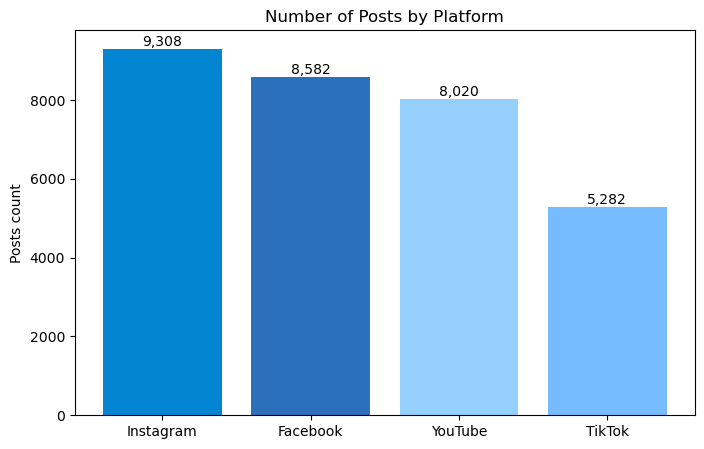

In [53]:
posts_by_platform = (
    df.groupby('platform')
      .size()
      .reset_index(name='posts_cnt')
)

posts_by_platform['platform'] = (
    posts_by_platform['platform']
    .astype(str)
    .str.strip()
)

posts_by_platform = posts_by_platform[
    posts_by_platform['platform'].isin(PLATFORM_COLORS.keys())
].sort_values('posts_cnt', ascending=False)

colors = posts_by_platform['platform'].map(PLATFORM_COLORS)

plt.figure(figsize=(8,5))
bars = plt.bar(
    posts_by_platform['platform'],
    posts_by_platform['posts_cnt'],
    color=colors
)

plt.title("Number of Posts by Platform")
plt.ylabel("Posts count")

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{int(bar.get_height()):,}",
        ha='center',
        va='bottom'
    )

plt.show()


##### Business conclusion: Instagram has the most content, but:
- engagement is 2.2x lower than TikTok
- likes are 2x lower than TikTok
- missing or incorrect views data

#### 3.2 Average engagement across platforms

In [47]:
def clean_platform(df):                           # We detected an empty string, so we are cleaning the data again           
    df = df.copy()
    df['platform'] = df['platform'].astype(str).str.strip()
    return df[df['platform'].isin([
        'YouTube', 'TikTok', 'Instagram', 'Facebook'
    ])]

In [48]:
print(clean_platform(df)['platform'].unique())    # Chtck

['Instagram' 'TikTok' 'Facebook' 'YouTube']


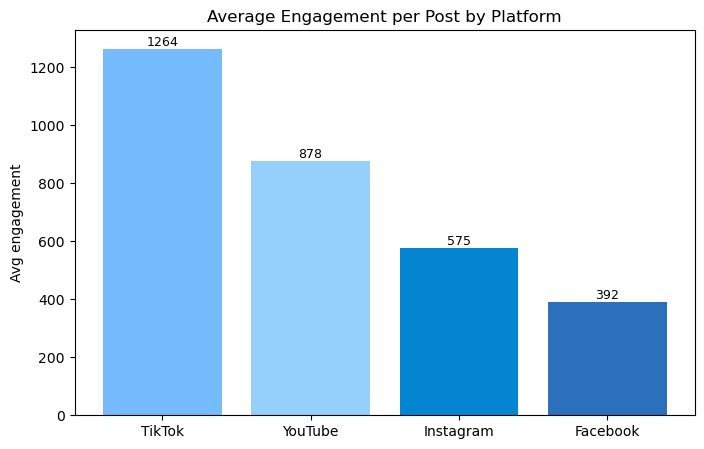

In [49]:
avg_engagement = (
    clean_platform(df)
    .groupby('platform', as_index=False)['engagement']
    .mean()
    .sort_values('engagement', ascending=False)
)

plt.figure(figsize=(8,5))                                # visualization
bars = plt.bar(
    avg_engagement['platform'],
    avg_engagement['engagement'],
    color=[PLATFORM_COLORS[p] for p in avg_engagement['platform']]
)

plt.title('Average Engagement per Post by Platform')
plt.ylabel('Avg engagement')
add_bar_labels(bars, fmt='{:.0f}')
plt.show()


#### Business conclusion: TikTok is the absolute leader in engagement. TikTok with the fewest posts:
- #1 in engagement
- #1 in likes
- #1 in comments
- #1 in views

#### 3.3 Average Likes per Post by Platform

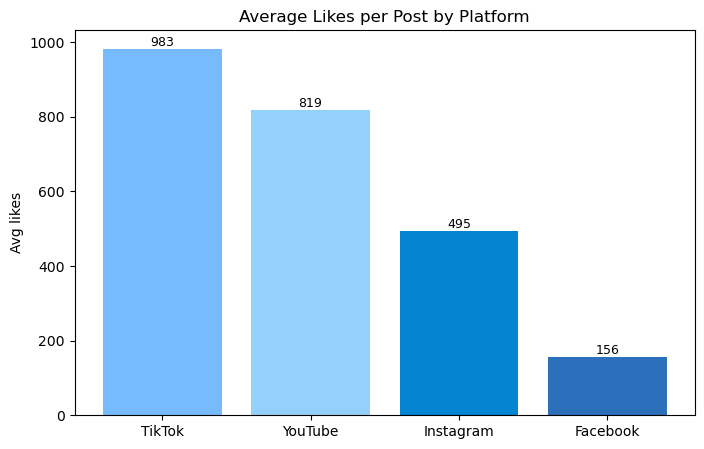

In [50]:
avg_likes = (
    clean_platform(df)
    .groupby('platform', as_index=False)['likes_count']
    .mean()
    .sort_values('likes_count', ascending=False)
)

plt.figure(figsize=(8,5))                          # visualization                       
bars = plt.bar(
    avg_likes['platform'],
    avg_likes['likes_count'],
    color=[PLATFORM_COLORS[p] for p in avg_likes['platform']]
)

plt.title('Average Likes per Post by Platform')
plt.ylabel('Avg likes')
add_bar_labels(bars)
plt.show()

#### Business conclusion: YouTube — stable reach without discussion. YouTube:
- second place in views
- second place in likes
- minimal comments

#### 3.4 Average Comments per Post by Platform

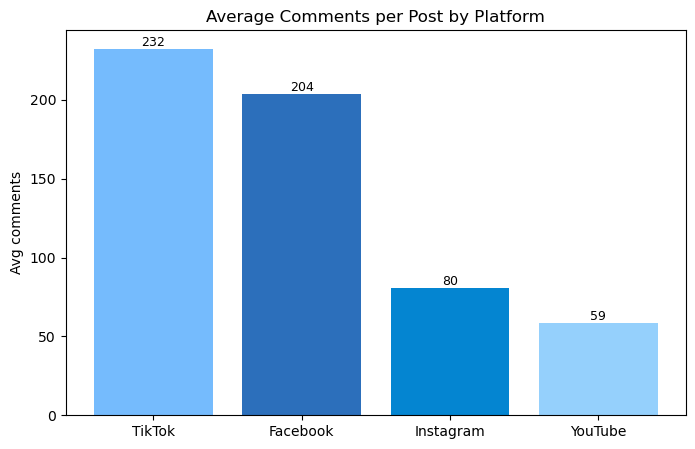

In [51]:
avg_comments = (
    clean_platform(df)
    .groupby('platform', as_index=False)['comments_count']
    .mean()
    .sort_values('comments_count', ascending=False)
)

plt.figure(figsize=(8,5))
bars = plt.bar(
    avg_comments['platform'],
    avg_comments['comments_count'],
    color=[PLATFORM_COLORS[p] for p in avg_comments['platform']]
)

plt.title('Average Comments per Post by Platform')
plt.ylabel('Avg comments')
add_bar_labels(bars)
plt.show()

#### Business conclusion: Facebook drives discussion, but not reach. Facebook:
- 2nd place in comments
- low likes and views

#### 3.5 Engagement dynamics by date

In [54]:
engagement_by_date = (
    clean_platform(df)
    .groupby(['post_date', 'platform'], as_index=False)['engagement']
    .mean()
)


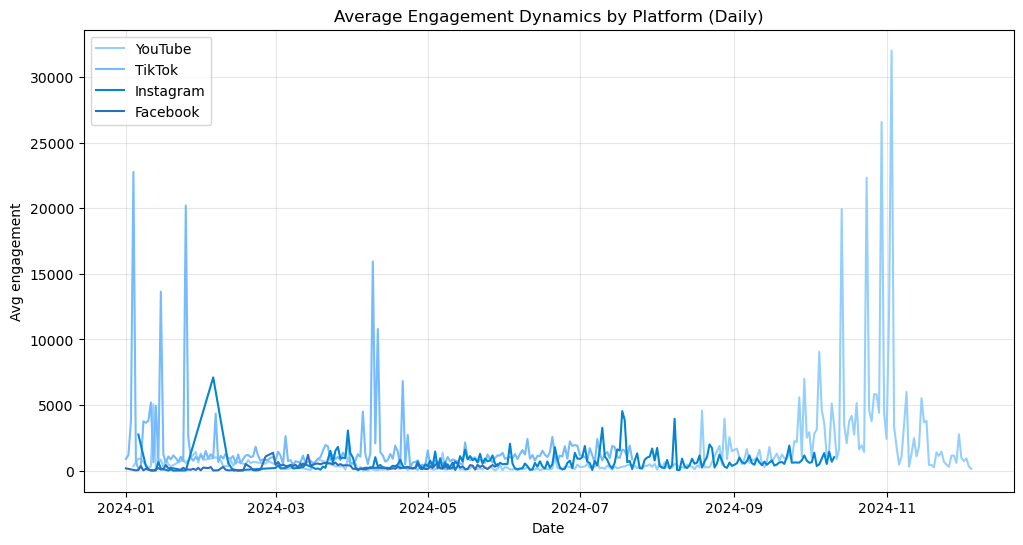

In [55]:
plt.figure(figsize=(12,6))

for platform, color in PLATFORM_COLORS.items():
    subset = engagement_by_date[engagement_by_date['platform'] == platform]
    plt.plot(
        subset['post_date'],
        subset['engagement'],
        label=platform,
        color=color
    )

plt.title('Average Engagement Dynamics by Platform (Daily)')
plt.xlabel('Date')
plt.ylabel('Avg engagement')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Business conclusion: average engagement per post by day shows:
- the highest peaks occur during the New Year holidays (end-beginning of the year) for TikTok and YouTube platforms.
- the lowest volatility (stability) is demonstrated by Instagram and Facebook platforms 

## 4. General conclusions by platforms:

### 1. TikTok — highest and most volatile engagement
Observation: TikTok consistently ranks above other platforms; sharp peaks in engagement are noticeable; between peaks — a quick return to the average
Interpretation: content often “shoots” due to recommendation algorithms; virality has a short life cycle
Business conclusion: TikTok needs frequent content testing; key focus — rapid scaling of successful formats;
regular posting is critical

### 2. YouTube is a stable, predictable trend.
Observation: YouTube’s curve is flatter; fewer sharp peaks and valleys; stable average engagement.
Interpretation: longer content lifecycle; engagement builds gradually.
Business takeaway: YouTube is suitable for long-term campaigns; works well as a “base” for a content strategy;
effective for evergreen content

### 3. Instagram — moderate level without sharp peaks
Observation: engagement is lower than TikTok and YouTube; no pronounced peak days; the curve looks relatively flat
Interpretation: content is consumed evenly; less virality, more volume-dependent
Business conclusion: Instagram — a channel to support presence; focus not on quantity, but on quality of formats; 
it is advisable to test new engagement mechanics

### 4. Facebook — local engagement spikes
Observation: overall level is lower than other platforms; local peaks appear periodically;
Interpretation: individual topics or events stimulate discussion; engagement depends on context, not regularity
Business conclusion: Facebook is effective for event-based content;
works well for discussions and socially sensitive topics; less effective for scaling reach

### Seasonality and synchronous peaks
Observation: on some days peaks appear on several platforms at once
Interpretation: influence of external factors: info drives, campaigns, events; confirms correlation between platforms
Business conclusion: it is advisable to synchronize publications; it is advisable to use single content hubs for launches

| Platform  | Role in strategy        |
| --------- | ----------------------- |
| TikTok    | Performance & Viral     |
| YouTube   | Long-term awareness     |
| Instagram | Presence & branding     |
| Facebook  | Engagement & discussion |


## 5. Key Insights
1. TikTok shows the highest engagement with strong volatility
2. YouTube demonstrates stable and predictable engagement patterns
3. Instagram has high posting volume but moderate engagement
4. Facebook has lower engagement with occasional spikes
5. Optimal posting hours differ significantly by platform
6. Engagement outliers have a strong impact on averages and should be analyzed separately

## 6. Business Conclusions
- Content strategy should be platform-specific
- TikTok is suitable for rapid testing and viral growth
- YouTube works best for long-term brand value
- Instagram and Facebook require optimization of formats and timing
- Continuous data quality checks are essential for reliable analytics